In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
#from skopt.space import Space
#from eml.net.reader import keras_reader

# Our Case Study

## Our Case Study

**As our next case study we will consider an _epidemic control_ problem**

<center><img src="assets/network.jpeg" width=750px /></center>

* Let's assume we are at early stages of an epidemic
* ...And we want to do our best to control while we wait for a cure/vaccine

## Epidemic Control as Optimization

**Technically, this is an optimization problem**

* We need to decide _which actions to take_
* ...Subject to a variety of _constraints_ (e.g. socio economical impact)
* ...So that the total number of infected is _minimized_

> **But how do we evaluate the impact of our actions?**

**Epidemical dynamics can be simulated**

* We can use differential equations
* We can use multi-agent models
* We can use networks to account for connections

## Epidemic Control as Optimization

**Technically, this is an optimization problem**

* We need to decide _which actions to take_
* ...Subject to a variety of constraints (e.g. socio economical impact)
* ...So that the number of infected is _minimized_

> **But how do we evaluate the impact of our actions?**

**However, using such simulator in optimization is _difficult_**

* They are defienned via rules and/or equations
* ...But using those in a declarative optimization approach is prohibitive
* Black-box optimization is an option, but cannot deal easily with constraints

## Empirical Model Learning

**We will tackle this problem via [Empirial Model Learning](https://emlopt.github.io/)**

The key idea in EML is to make ML models _part of_ optimization models

* We have learned how to inject a constraint model in ML...
* ...And now we will see how to inject ML into a constraint model

**EML was designed to enable optimization over complex systems, e.g.**

* Traffic optimization
* Thermal aware (computational) job scheduling
* Design of incentive schemes
* ...

**At its simplest, the approach requires to**

* Learn a ML model in any usual way
* Find a way to encode/embed the model in a given optimization technology

## Compartmental Models for Epidemics

**For our epidemics we will rely on a SIR model**

SIR models are a type of _compartmental model_

* The population is divided into three groups (compartments)
* ...I.e. Susceptibles, Infected, Recovered

**The classical SIR model is _dynamic system_**

* The size of the three groups evolves over time
* According to an Ordinary Differemtial Equation (ODE)

**An ODE is a differential equation in the form:**
$$
\dot{y} = f(y, t)
$$

* $y$ is a (vector) variable representing the system state
* $f(y, t)$ defines the _gradient_ of the state

## Compartmental Models for Epidemics

**In the case of the SIR model, we have:**

$$\begin{align}
\dot{S} & = -\beta \frac{1}{N}SI \\
\dot{I} & = \beta \frac{1}{N}SI - \gamma I \\
\dot{R} & = \gamma I
\end{align}$$

Where:

* $S$, $I$, $R$ refer to the size of each component
* $N$ is the population size (i.e. $N = S + I + R$
* ...$\beta$ is the _infection rate_ and $\gamma$ the _recovery rate_
* ...And the ratio $R_0 = \beta / \gamma$ is called _basic reproductive number_

## Compartmental Models for Epidemics

**In the case of the SIR model, we have:**

$$\begin{align}
\dot{S} & = -\beta \frac{1}{N}SI \\
\dot{I} & = \beta \frac{1}{N}SI - \gamma I \\
\dot{R} & = \gamma I
\end{align}$$

We have that:

* $S$ decreases proportionally to the product $S I$
* $I$ grows by the same rate, and decreases proportionally to its size $I$
* $R$ grows proportionally to $I$

Individiduals "flow" from $S$ to $I$, and then to $R$

## Solution Methods for ODEs

**Solving an ODE can be thought of as _running a simulation_**

The simples solution approach is called _Euler's method_

* $\text{$y(0) = $ initial system state, $t(0) = 0$}$
* $\text{for $i = 1..n_{steps}$}$
  - $t(i) = t(i-1) + h$
  - $y(i) = y(i-1) + h f\left(y(i-1), t(i-1)\right)$
  
**Intuitively:**

* We start from an initial state $y(0)$
* We make linear updates to the state, with step $h$ 
* ...Using $f(y, t)$ to compute the gradient
* We keep track of passing time in $t$

## Solving Our SIR

**First, we need to define a function to compute our gradient**

I.e. we simply need to compute the SIR formulas

```python
def SIR(y, beta, gamma):
    # Unpack the state
    S, I, R = y
    N = sum([S, I, R])
    # Compute partial derivatives
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    # Return gradient
    return np.array([dS, dI, dR])
```

* Rather than passing $N$ as a parameter
* ...Here we compute it on the fly

## Solving Our SIR

**Then we just need to call an ODE integration function**

We will use `odeint` from scipy

```python
odeint(f, y0, t, ...)
```

* `y0` is the initial state
* `t` is vector of time points
  - The function allows for _variable_ time steps
  - ...Defined via the differences `t[1:] - t[:-1]`
* `f` is the gradient computation function
  - ...And it should implement the interface `f(y, t)`
  - Alternative interfaces are possible (but we won't cover them)

## Solving Our SIR

**Our simulation code is in `simulate_SIR`**

```python
def simulate_SIR(S0, I0, R0, beta, gamma, tmax, steps_per_day=1):
    # Build initial state
    y0 = np.array([S0, I0, R0])
    # Wrapper
    nabla = lambda y, t: SIR(y, beta, gamma)
    # Solve
    t = np.linspace(0, tmax, steps_per_day * tmax)
    Y = odeint(nabla, y0, t)
    # Wrap as dataframe and return
    ...
```

* We use a `lambda` function to obtain the expected interface
* Each time unit corresponds to one day
* ...And we control the number of steps per day with `steps_per_day`

## Solving Our SIR

**Next, we define test values for all the parameters**

In [2]:
S0, I0, R0 = 0.99, 0.01, 0.0
beta, gamma = 0.1, 1/14
tmax = 365

* We consider a normalized population ($N = 1$)
* Initially, $1\%$ of the population is infected
* $\gamma$ is the inverse of the average recovery time (14 days)
* We simulate for one year

**The value of $R_0$ determines whether we have a proper epidemic behavior**

* If $R_0 > 1$ infections grow before falling, otherwise they only decrease
* We have $R_0 = \beta / \gamma = 1.4$, i.e. a true epidemic behavior

## Solving Our SIR

**Let's plot the dynamics for one year**

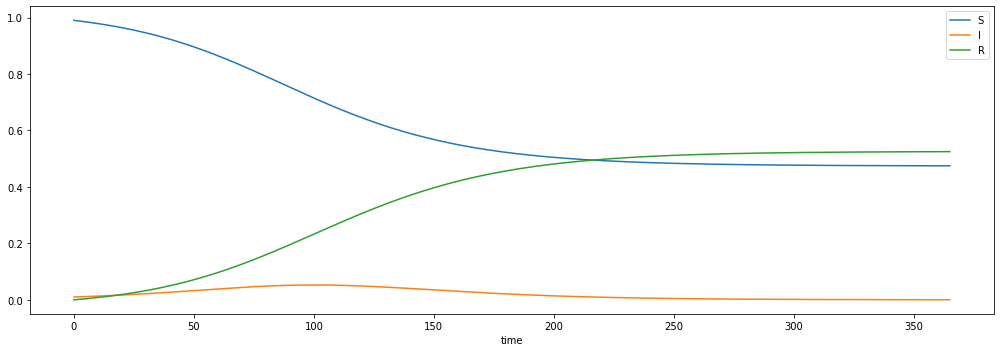

In [3]:
data = util.simulate_SIR(S0, I0, R0, beta, gamma, tmax=tmax, steps_per_day=1)
util.plot_df_cols(data, figsize=figsize)

* The $S$ compartment monotonically decreases
* The $R$ compartment monotonically increases

## Solving Our SIR

**Let's focus on the infected curve**

The number of infected grows, before decreasing again

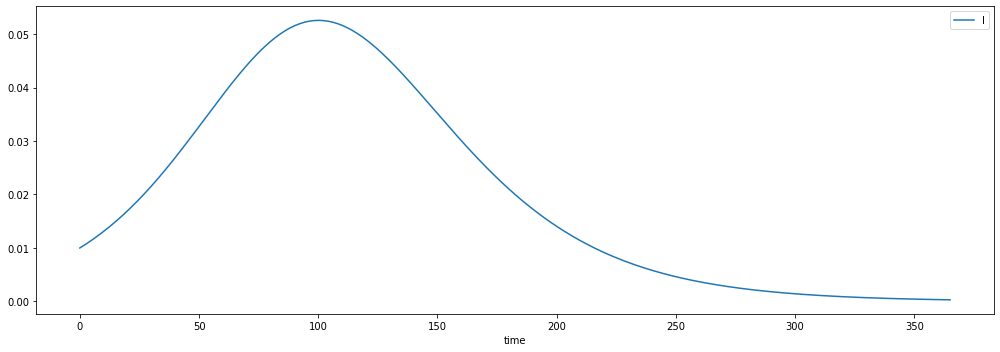

In [4]:
util.plot_df_cols(data[['I']], figsize=figsize)

* In a true epidemics, the behavior will be more complicated
* ...In particular, we will typically have multiple waves

## Solving Our SIR

**Let's focus on the infected curve**

The number of infected grows, before decreasing again

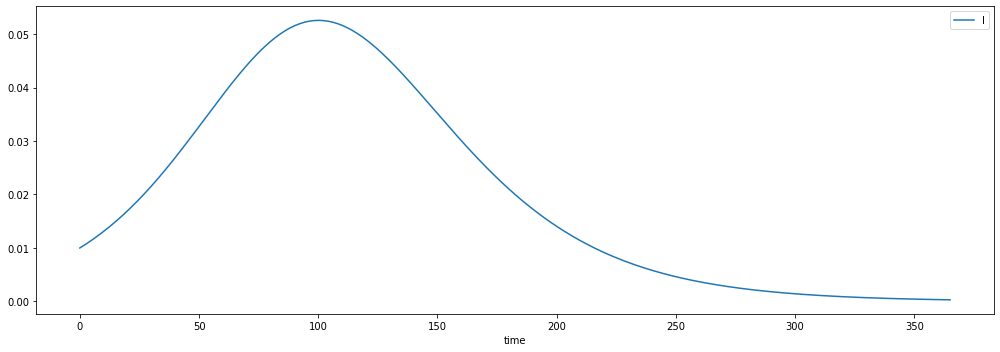

In [5]:
util.plot_df_cols(data[['I']], figsize=figsize)

* However, SIR models are still a good _local_ descriptor
* ...Which is why the $R_t$ values is routinely monitored